## Model1

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [11]:
df = pd.read_pickle('population_splits.pkl')
all_dfs = [
    df['Train']['Positive'],
    df['Train']['Negative'],
    df['Validation']['Positive'],
    df['Validation']['Negative'],
    df['Test']['Positive'],
    df['Test']['Negative']
]
combined_df = pd.concat(all_dfs, ignore_index=True)
codons_to_classify = ['ATG', 'CTG', 'GTG', 'TTG', 'AAG', 'ATA', 'ATT', 'ATC', 'ACG']

In [38]:
def mask_center_codon(one_hot_array):
    arr = np.array(one_hot_array)
    center = len(arr) // 2
    arr[center-1:center+2] = 0
    return arr

combined_df['Masked Encoding'] = combined_df['One Hot Encoding'].apply(mask_center_codon)
#combined_df['Masked Encoding'] = combined_df['One Hot Encoding']

# saliency map function
def compute_saliency(model, input_sequence):
    input_tensor = tf.convert_to_tensor(input_sequence[None], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    grads = tape.gradient(prediction, input_tensor).numpy()[0]
    saliency = np.abs(grads).sum(axis=-1)
    return saliency

# CNN
def build_model(input_shape):
    inputs = Input(shape=input_shape)

    # First block
    x = Conv1D(128, 7, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(2)(x)

    # Second block
    x = Conv1D(64, 5, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(2)(x)

    # Third block
    x = Conv1D(32, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(2)(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.4)(x)

    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)


In [39]:
transcripts = combined_df['Transcript'].unique()
train_ids, test_ids = train_test_split(transcripts, test_size=0.2, random_state=42)
codon_auc_scores = {}


 Codon: ATG
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train AUROC: 0.543
Test  AUROC: 0.537
Prediction range: 0.48678616 - 0.50348806
Peak saliency at position: 429


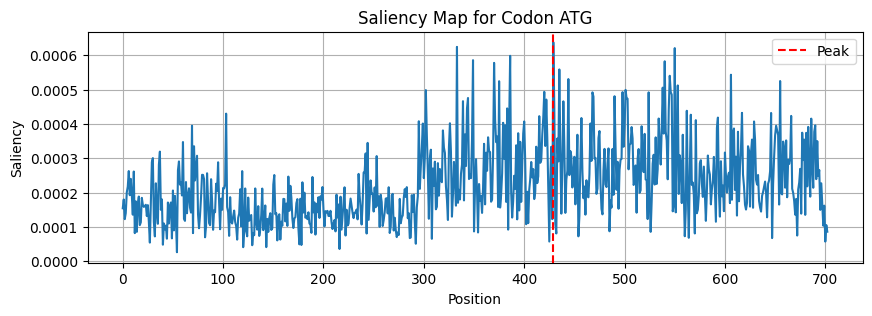


 Codon: CTG
522/522 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Train AUROC: 0.500
Test  AUROC: 0.500
Prediction range: 0.49564397 - 0.49878436
Peak saliency at position: 0


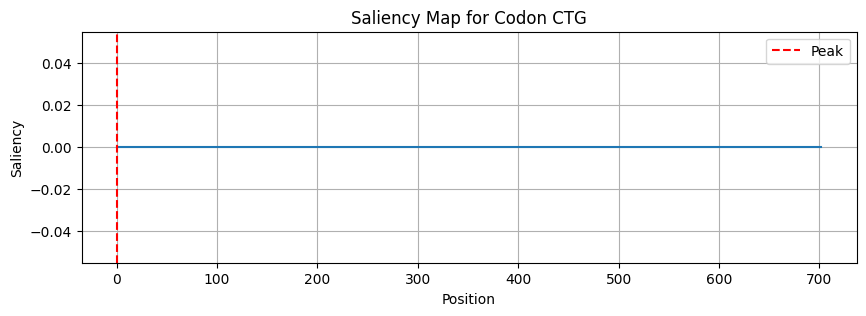


 Codon: GTG
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Train AUROC: 0.605
Test  AUROC: 0.534
Prediction range: 0.19149698 - 0.5196342
Peak saliency at position: 0


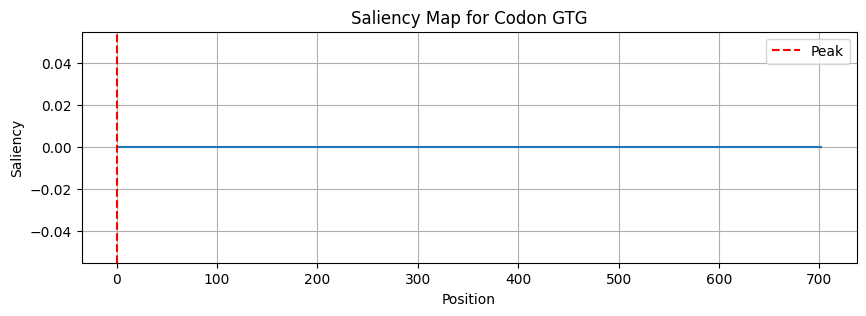


 Codon: TTG
255/255 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train AUROC: 0.512
Test  AUROC: 0.511
Prediction range: 0.5016213 - 0.5239572
Peak saliency at position: 0


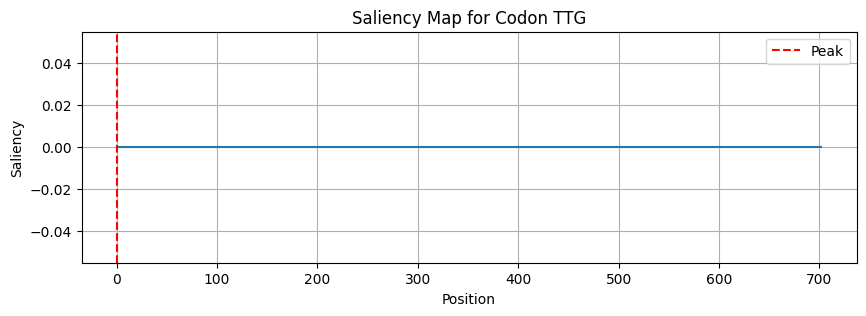


 Codon: AAG
294/294 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train AUROC: 0.640
Test  AUROC: 0.571
Prediction range: 0.48010582 - 0.7568084
Peak saliency at position: 354


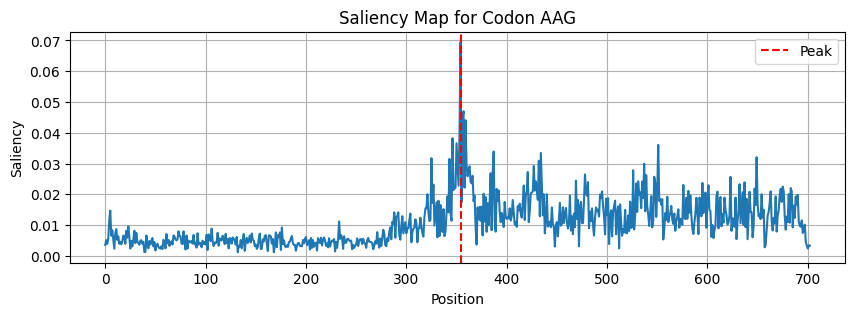


 Codon: ATA
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Train AUROC: 0.816
Test  AUROC: 0.720
Prediction range: 0.29479927 - 0.49582475
Peak saliency at position: 362


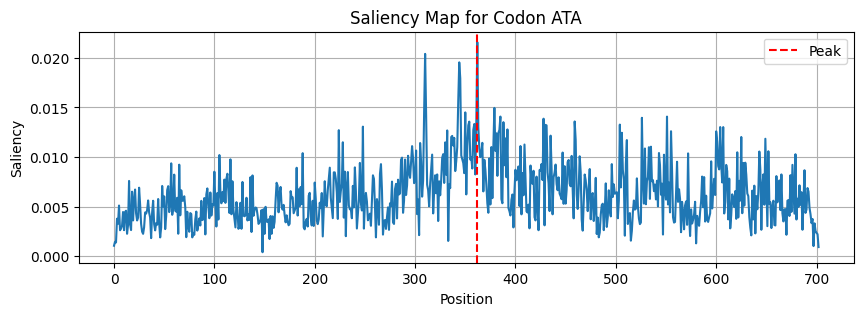


 Codon: ATT
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train AUROC: 0.639
Test  AUROC: 0.608
Prediction range: 0.47606984 - 0.510798
Peak saliency at position: 508


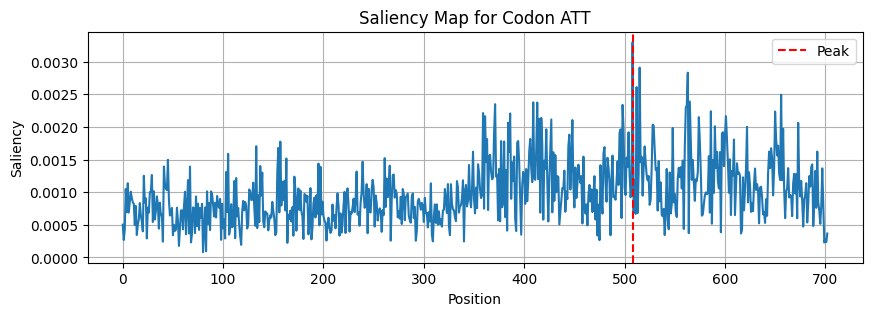


 Codon: ATC
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Train AUROC: 0.554
Test  AUROC: 0.533
Prediction range: 0.47218597 - 0.50363016
Peak saliency at position: 274


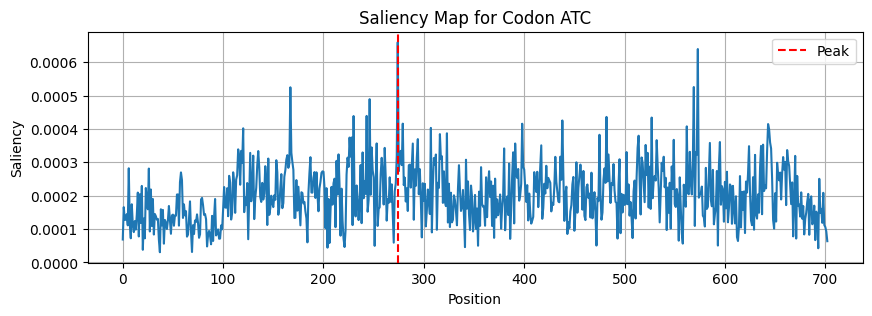


 Codon: ACG
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train AUROC: 0.509
Test  AUROC: 0.503
Prediction range: 0.5002199 - 0.50124913
Peak saliency at position: 0


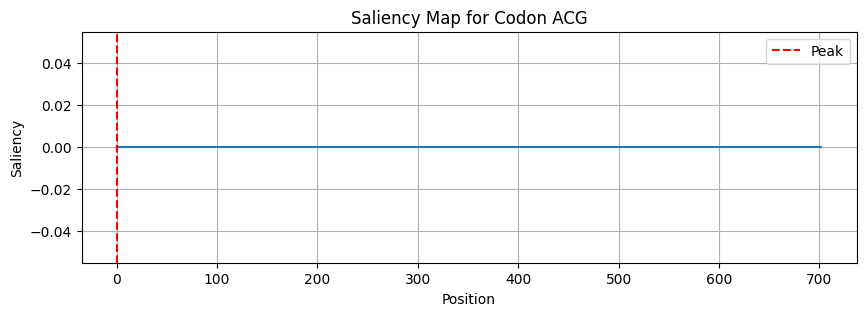

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
for codon in codons_to_classify:
    print(f"\n Codon: {codon}")

    df = combined_df.copy()
    df['Label'] = (df['Start Codon'] == codon).astype(int)

    pos_df = df[df['Label'] == 1]
    neg_df = df[df['Label'] == 0]

    if len(pos_df) < 50:
        print(f"Skipping {codon}: too few positives.")
        continue

    neg_df_balanced = neg_df.sample(n=len(pos_df), random_state=42)
    balanced_df = pd.concat([pos_df, neg_df_balanced]).sample(frac=1, random_state=42)

    train_df = balanced_df[balanced_df['Transcript'].isin(train_ids)].copy()
    test_df = balanced_df[balanced_df['Transcript'].isin(test_ids)].copy()

    #if train_df['Label'].sum() < 10 or test_df['Label'].sum() < 5:
        #print(f"Skipping {codon}: too few samples after split.")
        #   continue

    X_train = np.stack(train_df['Masked Encoding'].values)
    y_train = train_df['Label'].values
    X_test = np.stack(test_df['Masked Encoding'].values)
    y_test = test_df['Label'].values

    model = build_model(X_train.shape[1:])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, validation_split=0.1,
              epochs=20, batch_size=128, callbacks=[early_stop], verbose=0)

    y_train_pred = model.predict(X_train).flatten()
    y_test_pred = model.predict(X_test).flatten()

    train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_test, y_test_pred)

    codon_auc_scores[codon] = test_auc
    print(f"Train AUROC: {train_auc:.3f}")
    print(f"Test  AUROC: {test_auc:.3f}")
    if train_auc - test_auc > 0.1:
        print("overfitting")

    print("Prediction range:", y_test_pred.min(), "-", y_test_pred.max())

    pos_indices = np.where(y_test == 1)[0]
    if len(pos_indices) > 0:
        idx = pos_indices[0]
        saliency = compute_saliency(model, X_test[idx])
        peak_position = np.argmax(saliency)
        print(f"Peak saliency at position: {peak_position}")

        plt.figure(figsize=(10, 3))
        plt.plot(saliency)
        plt.axvline(x=peak_position, color='red', linestyle='--', label='Peak')
        plt.title(f"Saliency Map for Codon {codon}")
        plt.xlabel("Position")
        plt.ylabel("Saliency")
        plt.legend()
        plt.grid(True)
        plt.show()